## Data Preparation

Loads common imports, and defines some generic SPSS functions.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import savReaderWriter
import seaborn as sns

from osgeo import gdal

In [5]:
import common as c
ds = c.DataSet("data/acf.sav")


General instructions.

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Parameters
plt.rcParams["figure.figsize"] = (12,9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('/home/ubuntu/repos/fastai')

In [8]:
import fastai
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='/home/ubuntu/jupyter/data/path/'

Generate list of variables

In [11]:
import tabulate
from IPython.display import HTML, display
s = tabulate.tabulate(([x.decode('utf-8'), y.decode('utf-8')] for x, y in common.metadata.varLabels.items()), tablefmt='html')
with open("acf-metadata.html", "w") as text_file:
    text_file.write(s)
#display(HTML(s))

ModuleNotFoundError: No module named 'tabulate'

In [12]:
acf = ds.data

#### Scores

Music participation scores

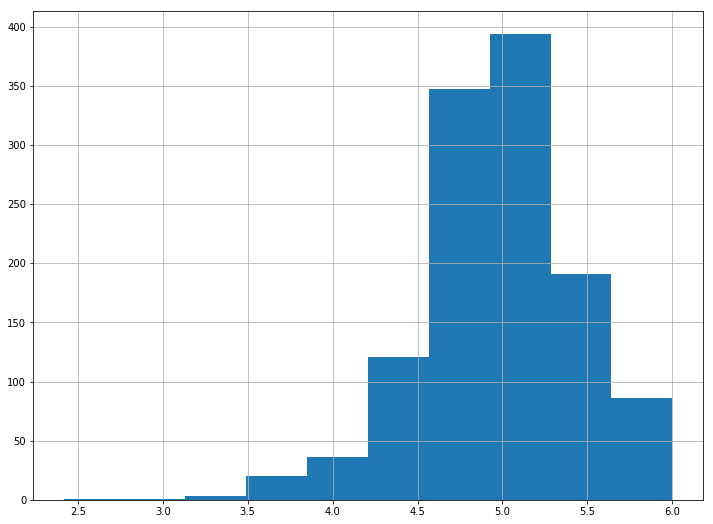

In [13]:
acf = acf.assign(score_music_hours = acf['Q24'])
acf = acf.assign(score_music_frequency = acf[['Q26A', 'Q26B', 'Q26C', 'Q26D', 'Q26E', 'Q26F']].sum(axis=1))
acf = acf.assign(score_music_consumption = (acf.score_music_hours / 4. ) + ( acf.score_music_frequency  / 6.) )
acf.score_music_consumption.hist();

In [25]:
acf.score_music_consumption.value_counts()

5.250000    146
5.083333    109
5.500000    100
4.750000     82
4.833333     74
4.916667     72
5.166667     71
5.000000     68
5.333333     58
4.583333     54
4.666667     46
4.500000     42
6.000000     32
4.416667     32
4.333333     27
5.666667     25
5.750000     18
5.416667     17
5.583333     16
4.250000     16
4.166667     12
5.833333     11
4.083333     11
4.583333     10
3.916667      8
3.833333      7
4.666667      6
4.000000      5
3.500000      4
4.416667      4
3.666667      4
3.583333      3
4.833333      3
3.750000      2
3.250000      2
3.416667      1
2.833333      1
2.416667      1
Name: score_music_consumption, dtype: int64

Heritage participation scores

In [ ]:
# Reverse order of art gallery visits
acf = acf.assign(score_heritage_internet = np.max(acf['Q37']) - acf['Q37'])
acf = acf.assign(score_heritage_visits = acf[['Q31C1', 'Q31C2', 'Q31C3', 'Q31C4', 'Q31C5', 'Q31C6', 'Q31C7', 'Q31C8', 'Q31C9', 'Q31C10', 'Q31C11']].sum(axis=1))
acf.loc[acf.score_heritage_visits < 0, 'score_heritage_visits'] = 0
acf = acf.assign(score_heritage_subscriber = acf[['Q32C1', 'Q32C2', 'Q32C3', 'Q32C4', 'Q32C5', 'Q32C6', 'Q32C7', 'Q32C8']].sum(axis=1))
acf = acf.assign(score_heritage_consumption = (acf.score_heritage_internet / 5. ) + ( acf.score_heritage_visits  / 11. )  + ( acf.score_heritage_subscriber / 8. ) )
acf.score_heritage_visits.hist();

Art participation scores

In [ ]:
# Reverse order of art gallery visits
acf = acf.assign(score_gallery = np.max(acf['Q38']) - acf['Q38'])
acf = acf.assign(score_locations = acf[['Q39C1', 'Q39C2', 'Q39C3', 'Q39C4', 'Q39C5', 'Q39C6', 'Q39C7', 'Q39C8']].sum(axis=1))
acf = acf.assign(score_internet = acf[['Q40C1', 'Q40C2', 'Q40C3', 'Q40C4']].sum(axis=1))
acf = acf.assign(score_art_consumption = ( (acf.score_gallery ) + ( acf.score_locations )  + ( acf.score_internet ) ) / 3. )

#plt.figure(); 
[(acf[a].plot.hist(alpha = 0.25, legend = True)) for a in ['score_gallery', 'score_locations', 'score_internet', 'score_art_consumption']];

In [ ]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
counter = 0
cols = ['score_gallery', 'score_locations', 'score_internet', 'score_art_consumption']
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        if counter < len(cols):
            col = cols[counter]
            ax.hist(acf[col].dropna(), bins=5, color='blue', alpha=0.5, label='{}'.format(acf[col]))
        else:
            ax.set_axis_off()
        counter += 1
plt.show()
        



Literature participation scores

In [ ]:
acf = acf.assign(score_lit_aus_books = acf['Q49'])
acf = acf.assign(score_lit_books = acf['Q50'])
acf = acf.assign(score_lit_ebooks = acf['Q51'])
acf = acf.assign(score_lit_attendance = acf[['Q53A', 'Q53B', 'Q53C', 'Q53D', 'Q53E', 'Q53F', 'Q53G']].sum(axis=1))
acf = acf.assign(score_literature_consumption = (acf.score_lit_aus_books / 8. ) + ( acf.score_lit_books  / 5. )  + ( acf.score_lit_ebooks  / 7. ) + ( acf.score_lit_attendance  / 7. ) )

acf.score_literature_consumption.hist();

#### Frequencies

In [ ]:
common.freq_table('sex')

In [ ]:
common.freq_table('soc8cla')

In [ ]:
common.freq_table('spaloc')

In [ ]:
common.freq_table('Q38')

In [ ]:
common.freq_table('Q24')

In [ ]:
common.freq_table('Q25')

In [ ]:
common.freq_table('Q37')

In [ ]:
common.freq_table('Q49')

In [ ]:
common.freq_table('Q50')

In [ ]:
common.freq_table('Q51')

In [ ]:
common.freq_table('Q56')

### Postcodes

In [ ]:
postcodes = pd.read_csv("data/POA_2016_AUST.csv")

### ABS LGAs

In [ ]:
names = ["POSTCODE",
            "CODE_2011",
            "NAME_2011",
            "RATIO",
            "PERCENTAGE"]

def readStatisticalAreas(file):
    sas = pd.read_csv(file, encoding = "ISO-8859-1")
    sas = sas.iloc[5:3115, 0:5]
    sas.columns = names
    sas = sas.iloc[3:3107,1:4]
    return sas

lgas = readStatisticalAreas("data/1270055006_CG_POSTCODE_2011_LGA_2011.csv")

In [ ]:
lgas.iloc[1,:]

### SEIFA 


In [ ]:
seifa_raw = pd.read_excel('./data/2033.0.55.001 POA Indexes.xls', sheet_name = 1)
seifa = seifa_raw.iloc[5:2487, 0:10]
seifa.columns = [ "postcode", "score_adv_disadv", "decile_adv_disadv", "score_disadv", "decile_disadv", "score_eco_resource", "decile_eco_resource", "score_edu_occ", "decile_edu_occ", "res_pop"]



In [ ]:
seifa[['score_adv_disadv', 'score_disadv', 'score_eco_resource', 'score_edu_occ']] = seifa[['score_adv_disadv', 'score_disadv', 'score_eco_resource', 'score_edu_occ']].apply(lambda x: pd.to_numeric(x, errors='coerce'))


In [ ]:
seifa.tail()

### Geographical Data

In [ ]:
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon

In [ ]:
d = gpd.read_file("./data/1270055003_poa_2016_aust_shape/POA_2016_AUST.dbf")

In [ ]:
d = d[d.geometry.notna()]

In [ ]:
d.head()

In [ ]:
d['centroids'] = d.geometry.centroid
d['centroids_x'] = d.geometry.centroid.x
d['centroids_y'] = d.geometry.centroid.y
d['postcode'] = d.POA_CODE16

In [ ]:
d['geom_sim'] = d.simplify(.001, preserve_topology = True)

#### Create Sydney Data

In [ ]:
cbd = d.loc[d.POA_CODE16 == "2000", ].centroids

In [ ]:
cbd.iloc[0].distance(d.iloc[0].centroids)

In [ ]:
syd = ["2000", "2006", "2007", "2008", "2009", "2010", "2011", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2032", "2035", "2036", "2037", "2038", "2039", "2040", "2041", "2042", "2043", "2044", "2048", "2049", "2050", "2203", "2204",  
        "2021", "2022", "2023", "2024", "2025", "2026", "2027", "2028", "2029", "2030", "2031", "2032", "2033", "2034", "2035", "2036",  
        "2172", "2205", "2207", "2208", "2209", "2210", "2216", "2217", "2218", "2219", "2220", "2221", "2222", "2223", "2224", "2225", "2226", "2227", "2228", "2229", "2230", "2231", "2232", "2233", "2234",  
        "2133", "2143", "2161", "2162", "2163", "2190", "2191", "2192", "2193", "2194", "2195", "2196", "2197", "2198", "2199", "2200", "2206", "2208", "2209", "2210", "2211", "2212", "2213", "2214", 
        "2161", "2163", "2164", "2165", "2166", "2168", "2170", "2171", "2172", "2173", "2174", "2175", "2176", "2177", "2178", "2179", "2555", "2556", "2557", "2565", "2745", 
        "2167", "2174", "2179", "2557", "2558", "2559", "2560", "2563", "2564", "2565", "2566", "2567", "2568", "2569", "2570", "2571", "2572", "2573", "2574", "2745", "2752", "2787", 
        "2045", "2046", "2047", "2130", "2131", "2132", "2133", "2134", "2135", "2136", "2137", "2138", "2140", "2190", "2191", "2193", 
        "2115", "2116", "2117", "2118", "2121", "2122", "2127", "2128", "2140", "2141", "2142", "2143", "2144", "2145", "2146", "2148", "2150", "2151", "2152", "2153", "2160", "2161", "2162", "2164", 
        "2178", "2745", "2747", "2748", "2749", "2750", "2753", "2754", "2755", "2756", "2757", "2758", "2759", "2760", "2765", "2773", "2774", "2775", "2776", "2777", "2778", "2779", "2780", "2782", "2783", "2784", "2785", "2786", 
        "2146", "2147", "2148", "2155", "2760", "2761", "2762", "2763", "2765", "2766", "2767", "2768", "2770", 
        "2060", "2061", "2062", "2063", "2064", "2065", "2066", "2067", "2068", "2069", "2088", "2089", "2090", "2109", "2110", "2111", "2112", "2113", "2114", "2122", 
        "2069", "2070", "2071", "2072", "2073", "2074", "2075", "2076", "2077", "2079", "2080", "2081", "2082", "2083", "2117", "2118", "2119", "2120", "2121", "2122", "2125", "2126", "2151", "2152", "2153", "2154", "2155", "2156", "2157", "2158", "2159", "2756", "2765", "2775", 
        "2084", "2085", "2086", "2087", "2092", "2093", "2094", "2095", "2096", "2097", "2099", "2100", "2101", "2102", "2103", "2104", "2105", "2106", "2107", "2108", 
        "2083", "2250", "2251", "2256", "2257", "2258", "2259", "2260", "2261", "2262", "2263", "2775"]

In [ ]:
acf_syd = acf[acf.Q4.isin(syd)]
acf_syd = acf_syd.assign(Q4 = acf_syd.Q4.astype('int32'))

In [ ]:
seifa_syd = seifa[seifa.postcode.isin(map(int, syd))]
seifa_syd.set_index(seifa_syd.postcode.astype('int32'), drop = True, inplace = True)

In [ ]:
d_syd = d[d.POA_CODE16.isin(syd)]
d_syd = d_syd.assign(dist_to_cbd = pd.Series([c.distance(cbd.iloc[0]) for c in d_syd.centroids]),
                     dist_to_cbd_lon = pd.Series([np.abs(cbd.iloc[0].x - c.x) for c in d_syd.centroids]),
                     dist_to_cbd_lat = pd.Series([np.abs(cbd.iloc[0].y - c.y) for c in d_syd.centroids]))

In [ ]:
d_syd.set_index(d_syd.POA_CODE16.astype('int32'), drop = True, inplace = True)

In [ ]:
score_gallery_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_gallery'], weights = x.WEIGHT) )
score_locations_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_locations'], weights = x.WEIGHT) )
score_internet_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_internet'], weights = x.WEIGHT) )
score_art_consumption_avg = acf_syd.groupby('Q4').apply(lambda x: np.average(x['score_art_consumption'], weights = x.WEIGHT) )

#### Merge data sets

In [ ]:
d_syd = d_syd.merge(pd.DataFrame(score_gallery_avg), how = 'left', left_index = True, right_index = True)
d_syd.rename(columns={0: 'score_gallery_avg'}, inplace=True)
d_syd = d_syd.merge(pd.DataFrame(score_locations_avg), how = 'left', left_index = True, right_index = True)
d_syd.rename(columns={0: 'score_locations_avg'}, inplace=True)
d_syd = d_syd.merge(pd.DataFrame(score_internet_avg), how = 'left', left_index = True, right_index = True)
d_syd.rename(columns={0: 'score_internet_avg'}, inplace=True)
d_syd = d_syd.merge(pd.DataFrame(score_art_consumption_avg), how = 'left', left_index = True, right_index = True)
d_syd.rename(columns={0: 'score_art_consumption_avg'}, inplace=True)

In [ ]:
d_syd = d_syd.merge(seifa_syd, how = 'left', left_index = True, right_index = True)

In [ ]:
d_syd.columns

In [ ]:
d_syd_corrs = d_syd[['dist_to_cbd', 'dist_to_cbd_lon', 'dist_to_cbd_lat', 'score_gallery_avg',
       'score_locations_avg', 'score_internet_avg',
       'score_art_consumption_avg', 
       'score_adv_disadv', 'score_disadv', 
       'score_eco_resource', 'score_edu_occ']]

### Initial Graphs

In [ ]:
gpd.GeoSeries(d_syd.geometry).plot();

In [ ]:
# d_syd.loc[d_syd.score_gallery_avg.isna(),'score_gallery_avg'] = 0.
# d_syd.loc[d_syd.score_locations_avg.isna(),'score_locations_avg'] = 0.
# d_syd.loc[d_syd.score_internet_avg.isna(),'score_internet_avg'] = 0.
# d_syd.loc[d_syd.score_art_consumption_avg.isna(),'score_art_consumption_avg'] = 0.


In [ ]:
ax = d_syd.plot(color="grey", alpha = 0.1)

d_syd_with_vals = d_syd[pd.notnull(d_syd['score_art_consumption_avg'])]
d_syd_with_vals.plot(ax = ax, column='score_art_consumption_avg', cmap = 'coolwarm');

In [ ]:
# From https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas

sm = pd.plotting.scatter_matrix(d_syd_corrs, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
sm;

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = d_syd_corrs.corr()
sns.heatmap(corr, vmin = -1.0, vmax = 1.0, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True),
            square=True, ax=ax);

## Density

Add [GDAL](http://www.gdal.org/) imports.

In [ ]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr


Load Australia's [2016 population densities](http://www.abs.gov.au/ausstats/abs@.nsf/Previousproducts/3218.0Main%20Features702015-16?opendocument&tabname=Summary&prodno=3218.0&issue=2015-16&num=&view=), supplied by ABS. These figures are derived from "estimated residential populations" measured in $1km^2$ grid cells, which they term Australian Population Grid (APG). ABS refers to these as Australian Population Grid. Pre-computed average densities are available in KML format for LGA and SA2 but not for postcode levels. 

The steps below compute average and maximum densities for postcodes. It uses the ESRI Shapefile format, available on the ABS's APG [Downloads](http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3218.02015-16?OpenDocument) page.



In [ ]:
#apg_src = gdal.Open("./data/apg_2016/apg16e_1_0_0/", gdal.GA_ReadOnly)
apg_src = gdal.Open("./data/apg1617e_1", gdal.GA_ReadOnly)


Check the transformation data. Details obtained from <http://geoinformaticstutorial.blogspot.com.au/2012/09/reading-raster-data-with-python-and-gdal.html>.

In [ ]:
geotransform = apg_src.GetGeoTransform() 
print("top left x :", geotransform[0]) # top left x 
print("w-e pixel resolution :", geotransform[1]) # w-e pixel resolution 
print("rotation, 0 if image is 'north up' :", geotransform[2]) # rotation, 0 if image is "north up" 
print("top left y :", geotransform[3]) # top left y 
print("rotation, 0 if image is 'north up' :", geotransform[4]) # rotation, 0 if image is "north up" 
print("n-s pixel resolution *:", geotransform[5]) # n-s pixel resolution *
    

Print the minimum and maximum grid coordinates.

In [ ]:
minx = geotransform[0]
miny = geotransform[3]
stepx = geotransform[1]
stepy = geotransform[5]
maxx = minx + geotransform[1] * apg_src.RasterXSize
maxy = miny + geotransform[5] * apg_src.RasterYSize

print("Projection details (minimum): ", (minx, miny))
print("Step details: ", (stepx, stepy))
print("Projection details (maximum): ", (maxx, maxy))

Print the grid's projection details.

In [ ]:
prj_wkt = apg_src.GetProjection()
print("Projection details: ", prj_wkt)

Print the number of bands in the raster file.

In [ ]:
print("[ RASTER BAND COUNT ]: ", apg_src.RasterCount)

Print details about the first (and what should be the only) raster band.

In [ ]:
srcband = apg_src.GetRasterBand(1)

In [ ]:
print("[ NO DATA VALUE ] = ", srcband.GetNoDataValue())
print("[ MIN ] = ", srcband.GetMinimum())
print("[ MAX ] = ", srcband.GetMaximum())
print("[ SCALE ] = ", srcband.GetScale())
print("[ UNIT TYPE ] = ", srcband.GetUnitType())

Define the start (X,Y) - North and West - coordinates for Sydney, and read in the following $100^2 (= 10,000)$ cells. For rendering purposes, values less than zero are replaced with zeros. 

The furthermost East coordinates should have zero densities -- they should be in the ocean!

In [ ]:
start_x, start_y = 5583, 2763
pxls = srcband.ReadAsArray(start_x, start_y, 100, 100).astype(np.float)
pxls[pxls < 0] = 0

print("North West corner density: ", pxls[0,0])
print("North East corner density: ", pxls[0,99])
print("South West corner density: ", pxls[99,0])
print("South East corner density: ", pxls[99,99])

Free up resources.

In [ ]:
# apg_src = None
# srcband = None

Plot the densities.

In [ ]:
im = pxls
im[im == -3.4028234663852886e+38] = 0
plt.imshow(im, cmap=plt.cm.Greys,vmin = 0,vmax = np.max(pxls));

Develop transformations to and from the ABS Shapefile representation and longitude/latitude.

Formats are defined by [EPSG](http://www.epsg.org/) (European Petroleum Survey Group). 

In [ ]:
# Add the points
points = []
for i in range(pxls.shape[1]):
    for j in range(pxls.shape[0]):
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(minx + start_x * stepx + j*1000, miny + start_y * stepy + i * stepy, pxls[i, j])
        points.append(point)

# Convert to Numpy array
points = np.array(points)

# The existing projection
inSpatialRef = osr.SpatialReference(wkt=prj_wkt)

# The standard long./lat. format
outputEPSG = 4326
outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(outputEPSG)

# In -> Out
forwardTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
# Out -> In
backTransform = osr.CoordinateTransformation(outSpatialRef, inSpatialRef)

# Functions mapping forward and back
def f(pt):
    return pt.Transform(forwardTransform)

def b(pt):
    return pt.Transform(backTransform)

# # An alternative vectorised form - for now, not working
# transformer = lambda pt: pt.Transform(coordTransform)
# vfunc = np.vectorize(f)

# Test forward and back
print("Initial point: ", points[0])

# Comprehension conversion: forward
[f(pt) for pt in points]
print("Converted point: ", points[0])

# Comprehension conversion: Back
[b(pt) for pt in points]
print("Converted back (= initial): ", points[0])



Retrieve points from the geometry.

In [ ]:
from shapely.geometry import shape, mapping, Point
points_sim = np.array([p.GetPoint() for p in points])
print("Simplified point representation:", points_sim[0]) 

Convert point array back into a *map height x width* representation. This will make calculating mean and maximum densities for postcode shapes easier.

In [ ]:
points_shp = np.reshape(points_sim, (pxls.shape[1], pxls.shape[0], 3))
print("Shape of points_shp:", points_shp.shape)
xmin, ymin, _ = points_shp[0, 0]
print("NW coordinates: ", (xmin, ymin))
xmax, ymax, _ = points_shp[99, 99]
print("SE coordinates: ", (xmax, ymax))


First, create a 2-dimensional array, where the first dimension is equal to the number of Sydney postcodes.

Then, iterate through each of the postcode shapes, and add all point values (representing $1km^2$ residential population) within those shapes to the corresponding arrays.

As an optimisation, only points within the rectangular bounds of the shapes are tested for whether they belong to the shapes themselves.

In [ ]:
d_pts = [[] for i in range(len(d_syd))]

for i in range(len(d_syd)):
    # Obtain the bounds
    gxmin, gymin, gxmax, gymax = d_syd.iloc[i].geom_sim.bounds
    # Convert the bounds to the ESPG format of the population grid.
    gmin = ogr.Geometry(ogr.wkbPoint)
    gmin.AddPoint(gxmin, gymin)
    b(gmin)
    gmin = gmin.GetPoint()
    gmax = ogr.Geometry(ogr.wkbPoint)
    gmax.AddPoint(gxmax, gymax)
    b(gmax)
    gmax = gmax.GetPoint()
    # Obtain the offsets into the grid representation itself
    xomin = int(np.round((gmin[0] - xmin) / stepx))
    xomax = int(np.round((gmax[0] - xmin)  / stepx))
    yomin = int(np.round((gmax[1] - ymin) / stepy))
    yomax = int(np.round((gmin[1] - ymin) / stepy))
    # Slice the 2-dimensional APG representation, and for ease of iteration, flatten to a (10,000, 3) array.
    lpts = points_shp[yomin:yomax+1, xomin:xomax+1, :]
    lpts = (np.reshape(lpts, (lpts.shape[0] * lpts.shape[1],3)))
    
    # Iterate through the point to test for inclusion with this shape.
    for pt in lpts:
        pt0 = ogr.Geometry(ogr.wkbPoint)
        pt0.AddPoint(pt[0], pt[1])
        # This time, convert the grid representation to the postcode shapefile representation.
        f(pt0)
        pt_sim = Point(pt0.GetPoint()[0], pt0.GetPoint()[1])
        # Test whether the point belongs to the postcode, and add it to the array if so.
        if pt_sim.within(d_syd.iloc[i].geom_sim):
            # Ignore the coordinates - just append the value
            d_pts[i].append(pt[2])


Convert the resulting array to a Numpy equivalent, and obtain mean and maximum values.

In [ ]:
d_pts = [[0] if len(x) == 0 else x for x in d_pts]
d_pts = np.array(d_pts)
pt_mns = np.array([np.nanmean(x) for x in d_pts])
pt_mxs = np.array([np.nanmax(x) for x in d_pts])
print("Maximum postcode mean: ", max(pt_mns))
print("Minimum postcode mean: ", min(pt_mns))

print("Maximum postcode max: ", max(pt_mxs))
print("Minimum postcode max: ", min(pt_mxs))



An alternative and simpler version. Not working, as none of the EPSG codes reported in the projection are found.

In [ ]:
# from pyproj import Proj, transform

# inProj = Proj(init='epsg:7019')
# outProj = Proj(init='epsg:4326')
# x1,y1 = -3853000.0,-1012000.0
# x2,y2 = transform(inProj,outProj,x1,y1)
# print(x2,y2)

Normalise densities and log of densities.

In [ ]:
pt_mns_norm = (pt_mns + 1.)  / np.max((pt_mns + 1.))
pt_mns_norm_log = np.log(pt_mns + 1.)  / np.max(np.log(pt_mns + 1.))

Plots the normalised densities.

In [ ]:
from descartes.patch import PolygonPatch

plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

# build the polygon from exterior points
bounds = d_syd.geometry.bounds
for i in range(len(d_syd.geom_sim)):
    p = d_syd.iloc[i].geom_sim
    intensity = pt_mns_norm[i]
    patch = PolygonPatch(p, facecolor=[0,0,intensity], edgecolor=[0,0,0], alpha=0.7, zorder=2)
    ax.add_patch(patch)

# use bbox (bounding box) to set plot limits
plt.xlim(np.min(bounds.minx),np.max(bounds.maxx))
plt.ylim(np.min(bounds.miny),np.max(bounds.maxy))


Plots the normalised log densities.

In [ ]:
plt.figure()
ax = plt.axes()
ax.set_aspect('equal')

# build the polygon from exterior points
bounds = d_syd.geometry.bounds
for i in range(len(d_syd.geom_sim)):
    p = d_syd.iloc[i].geom_sim
    intensity = pt_mns_norm_log[i]
    patch = PolygonPatch(p, facecolor=[0,0,intensity], edgecolor=[0,0,0], alpha=0.7, zorder=2)
    ax.add_patch(patch)

# use bbox (bounding box) to set plot limits
plt.xlim(np.min(bounds.minx),np.max(bounds.maxx))
plt.ylim(np.min(bounds.miny),np.max(bounds.maxy))


In [228]:
acf.to_csv('data/acf.csv')

# Deep Learning Experiments

In [26]:
import torch

In [177]:
acf['dummy'] = 0.


In [178]:
# cat_vars = ['Q39C1']
cat_vars = ['STATE', 'Q38', 'Q39C1', 'Q39C2', 'Q39C3', 'Q39C4', 'Q39C5', 'Q39C6', 'Q39C7', 'Q39C8', 'Q39C9', 
           'Q40C1', 'Q40C2', 'Q40C3', 'Q40C4', 'Q40C5', 'sex', 'emplst']
# , 'soc8cla'

# contin_vars = ['soc4cla']
contin_vars = ['dummy']
#contin_vars = ['Q38', 'soc8cla', 'soc4cla', 'soc3cla']
#contin_vars = ['soc8cla']

In [179]:
contin2_vars = []
# contin2_vars = ["Q5", "Q16", "Q24", "Q25", "Q37", "q49", "q50", "q51", "q56", ]

In [180]:
contin2_vars = [t.upper() for t in contin2_vars]
print(contin2_vars)

[]


In [181]:
cat2_vars = ["Q5", "Q16", "Q24", "Q25", "Q37", "q49", "q50", "q51", "q56", ]
cat2_vars = ["Q7c1", "Q7c2", "Q7c3", "Q7c4",
              "Q7c5", "Q7c6", "Q7c7", "Q7c8", "Q7c9", "Q7c10", "Q7c11", "Q8c1", "Q8c2", "Q8c3", "Q8c4", "Q8c5", "Q8c6", "Q8c7", "Q8c8", "Q8c9", "Q8c10", "Q8c11", "Q9c1", "Q9c2", "Q9c3", "Q9c4", "Q9c5", "Q9c6", "Q9c7", "Q9c8", "Q9c9", "Q13a_1", "Q13a_2", "Q13b_1", "Q13b_2", "Q13c_1", "Q13c_2", "Q13d_1", "Q13d_2", "Q13e_1", "Q13e_2", "Q13f_1", "Q13f_2", "Q13g_1"]
cat2_vars += ["Q13g_2", "Q13h_1", "Q13h_2", "Q13i_1", "Q13i_2", "Q13j_1", "Q13j_2", "Q14a_1", "Q14a_2", "Q14b_1", "Q14b_2", "Q14c_1", "Q14c_2", "Q14d_1", "Q14d_2", "Q14e_1", "Q14e_2", "Q14f_1", "Q14f_2", "Q14g_1", "Q14g_2", "Q14h_1", "Q14h_2", "Q14i_1", "Q14i_2", "Q14j_1", "Q14j_2", "Q15a_1", "Q15a_2", "Q15b_1", "Q15b_2", "Q15c_1", "Q15c_2", "Q15d_1", "Q15d_2", "Q15e_1", "Q15e_2", "Q15f_1", "Q15f_2", "Q15g_1", "Q15g_2", "Q15h_1", "Q15h_2", "Q15i_1", "Q15i_2", "Q15j_1", "Q15j_2",  "Q17", "Q18c1", "Q18c2", "Q18c3", "Q18c4", "Q18c5", "Q18c6", "Q18c7", "Q18c8", "Q18c9", "Q18c10", "Q18c11", "Q19c1", "Q19c2", "Q19c3", "Q19c4", "Q19c5", "Q19c6", "Q19c7", "Q19c8", "Q19c9", "Q19c10", "Q19c11", "Q20c1", "Q20c2", "Q20c3", "Q20c4", "Q20c5", "Q20c6", "Q20c7", "Q20c8", "Q20c9", "Q20c10", "Q20c11", "Q21c1", "Q21c2", "Q21c3", "Q21c4", "Q21c5", "Q21c6", "Q21c7", "Q21c8", "Q21c9", "Q21c10", "Q22a_1", "Q22a_2", "Q22b_1", "Q22b_2", "Q22c_1", "Q22c_2", "Q22d_1", "Q22d_2", "Q22e_1", "Q22e_2", "Q22f_1", "Q22f_2", "Q22g_1", "Q22g_2", "Q22h_1", "Q22h_2", "Q22i_1", "Q22i_2", "Q22j_1", "Q22j_2", "Q23a_1", "Q23a_2", "Q23b_1", "Q23b_2", "Q23c_1", "Q23c_2", "Q23d_1", "Q23d_2", "Q23e_1", "Q23e_2", "Q23f_1", "Q23f_2", "Q23g_1", "Q23g_2", "Q23h_1", "Q23h_2", "Q23i_1", "Q23i_2", "Q23j_1", "Q23j_2"]
cat2_vars += ["Q26a", "Q26b", "Q26c", "Q26d", "Q26e", "Q26f", "Q27c1", "Q27c2", "Q27c3", "Q27c4", "Q27c5", "Q27c6", "Q27c7", "Q27c8", "Q27c9", "Q27c10", "Q27c11", "Q28c1", "Q28c2", "Q28c3", "Q28c4", "Q28c5", "Q28c6", "Q28c7", "Q28c8", "Q28c9", "Q28c10", "Q28c11", "Q29a_1", "Q29a_2", "Q29b_1", "Q29b_2", "Q29c_1", "Q29c_2", "Q29d_1", "Q29d_2", "Q29e_1", "Q29e_2", "Q29f_1", "Q29f_2", "Q29g_1", "Q29g_2", "Q29h_1", "Q29h_2", "Q29i_1", "Q29i_2", "Q29j_1", "Q29j_2", "Q30a_1", "Q30a_2", "Q30b_1", "Q30b_2", "Q30c_1", "Q30c_2", "Q30d_1", "Q30d_2", "Q30e_1", "Q30e_2", "Q30f_1", "Q30f_2", "Q30g_1", "Q30g_2", "Q30h_1", "Q30h_2", "Q30i_1", "Q30i_2", "Q30j_1", "Q30j_2", "Q31c1", "Q31c2", "Q31c3", "Q31c4", "Q31c5", "Q31c6", "Q31c7", "Q31c8", "Q31c9", "Q31c10", "Q31c11", "Q32c1", "Q32c2", "Q32c3", "Q32c4", "Q32c5", "Q32c6", "Q32c7", "Q32c8", "Q33a_1", "Q33a_2", "Q33b_1", "Q33b_2", "Q33c_1", "Q33c_2", "Q33d_1", "Q33d_2", "Q33e_1", "Q33e_2", "Q33f_1", "Q33f_2", "Q33g_1", "Q33g_2", "Q33h_1", "Q33h_2", "Q33i_1", "Q33i_2", "Q33j_1", "Q33j_2", "Q34a_1", "Q34a_2", "Q34b_1", "Q34b_2", "Q34c_1", "Q34c_2", "Q34d_1", "Q34d_2", "Q34e_1", "Q34e_2", "Q34f_1", "Q34f_2", "Q34g_1", "Q34g_2", "Q34h_1", "Q34h_2", "Q34i_1", "Q34i_2", "Q34j_1", "Q34j_2", "Q35c1", "Q35c2", "Q35c3", "Q35c4", "Q35c5", "Q35c6", "Q35c7", "Q35c8", "Q35c9"]
cat2_vars += ["Q36c1", "Q36c2", "Q36c3", "Q36c4", "Q36c5", "Q36c6", "Q36c7", "Q36c8", "Q36c9", "Q41c1", "Q41c2", "Q41c3", "Q41c4", "Q41c5", "Q41c6", "Q41c7", "Q41c8", "Q41c9", "Q41c10", "Q41c11", "Q42c1", "Q42c2", "Q42c3", "Q42c4", "Q42c5", "Q42c6", "Q42c7", "Q42c8", "Q42c9", "Q42c10", "Q42c11", "Q43a_1", "Q43a_2", "Q43b_1", "Q43b_2", "Q43c_1", "Q43c_2", "Q43d_1", "Q43d_2", "Q43e_1", "Q43e_2", "Q43f_1", "Q43f_2", "Q43g_1", "Q43g_2", "Q43h_1", "Q43h_2", "Q43i_1", "Q43i_2", "Q43j_1", "Q43j_2", "Q44a_1", "Q44a_2", "Q44b_1", "Q44b_2", "Q44c_1", "Q44c_2", "Q44d_1", "Q44d_2", "Q44e_1", "Q44e_2", "Q44f_1", "Q44f_2", "Q44g_1", "Q44g_2", "Q44h_1", "Q44h_2", "Q44i_1", "Q44i_2", "Q44j_1", "Q44j_2", "Q45c1", "Q45c2", "Q45c3", "Q45c4", "Q46c1", "Q46c2", "Q46c3", "Q46c4", "Q46c5", "Q46c6", "Q46c7", "Q46c8", "Q46c9", "Q46c10", "Q46c11", "Q46c12", "Q46c13", "Q46c14", "Q47a_1", "Q47a_2", "Q47b_1", "Q47b_2", "Q47c_1", "Q47c_2", "Q47d_1"]
cat2_vars += ["Q47d_2", "Q47e_1", "Q47e_2", "Q47f_1", "Q47f_2", "Q47g_1", "Q47g_2", "Q47h_1", "Q47h_2", "Q47i_1", "Q47i_2", "Q47j_1", "Q47j_2", "Q48", "Q48a_1", "Q48a_2", "Q48b_1", "Q48b_2", "Q48c_1", "Q48c_2", "Q48d_1", "Q48d_2", "Q48e_1", "Q48e_2", "Q48f_1", "Q48f_2", "Q48g_1", "Q48g_2", "Q48h_1", "Q48h_2", "Q48i_1", "Q48i_2", "Q48j_1", "Q48j_2", "Q52c1", "Q52c2", "Q52c3", "Q52c4", "Q52c5", "Q52c6", "Q52c7", "Q52c8", "Q52c9", "Q52c10", "Q53a", "Q53b", "Q53c", "Q53d", "Q53e", "Q53f", "Q53g", "Q54a", "Q54b", "Q54c", "Q54d", "Q54e", "Q54f", "Q54g", "Q54h", "Q57c1", "Q57c2", "Q57c3", "Q57c4", "Q57c5", "Q57c6", "Q57c7"]

cat3_vars = ["Q58", "Q59", "Q60", "Q61", "Q62", "Q63", "Q64", "Q64o", "Q65", "Q65o", "Q66", "Q67_pipe", "Q67", "Q67o", "Q68", "Q68o", "Q67_abs", "Q69", "Q70", "Q71", "Q72c1", "Q72c2", "Q72c3", "Q72a", "Q72b", "Q73", "Q74_pipe", "Q74", "Q74o", "Q74_abs", "Q75", "Q76c1", "Q76c2", "Q76c3", "Q77", "Q78", "Q79c1", "Q79c2", "Q79c3", "Q79c4", "Q80", "Q80o", "Q83", "Q83o", "Q84", "Q84ac1", "Q84ac2", "Q84ac3", "Q84ac4", "Q84ac5", "Q84ac6", "Q84ac7", "Q85", "Q85o", "Q86", "Q86o", "Q87c1", "Q87c2", "Q87c3", "Q87c4", "Q87c5", "Q87c6", "Q87c7", "Q87c8", "Q87c9", "Q87c10", "Q87c10o", "Q87c11", "Q88a", "Q88b", "Q89", "Q90_select", "Q90", "Q90a", "Q91", "Q92", "Q95", "int99", "int990", "issues", "issueso", "agec7", "nphouh", "educa", "sisoccl", "housinc", "tvwatch", "nitv", "tvauspr", "houlmus", "nebookh", "nbookho", "tspind", "tstind", "tskind", "tspaus", "tstaus", "tskaus", "tspusa", "tstusa", "tskusa", "tspuk", "tstuk", "tskuk", "tspeu", "tsteu", "tskeu", "tspasi", "tstasi", "tskasi", "emplst", "soc8cla", "soc5cla", "soc3cla", "ausenor", "clapref", "sex", "age", "nphouh1", "tvtech", "fatvch", "educap", "edespf", "univst", "coubirt", "educam", "educaf", "valubus", "homwor", "soc4cla", "fatvch1", "Q11o1"]

cat2_vars = [t.upper() for t in cat2_vars]
cat3_vars = [t.upper() for t in cat3_vars]

In [182]:
cat_vars += cat2_vars
contin_vars += contin2_vars

In [183]:
#dep = 'age'
#dep = 'Q61'
dep = 'sex'
cat_vars.remove(dep)

In [184]:
sacf = acf[['RecordNo', 
            dep] + cat_vars + contin_vars]
sacf = sacf.sample(frac=1)

In [185]:
# sacf['age'] = sacf.loc[:,'age'].interpolate()

In [186]:
sacf.dropna(axis=0, how='any', subset=[dep], inplace=True)

In [187]:
#sacf['age'] = sacf['age'].fillna(sacf['age'].mean())

In [188]:
len(sacf['RecordNo'])

1202

In [189]:
#for i in sacf.columns: print(i)

In [190]:
n = len(sacf); n

1202

In [191]:

for v in cat_vars: sacf[v] = sacf[v].astype('category').cat.as_ordered()
for v in contin_vars: sacf[v] = sacf[v].astype('float32')
sacf[dep].astype('float32')
# sacf[dep] = sacf[dep].astype('category').cat.as_ordered()
sacf = sacf[cat_vars+contin_vars+[dep, "RecordNo"]]

In [192]:
sacf['sex'] = sacf['sex'] + 1

In [193]:
idxs = get_cv_idxs(n, val_pct=1202/n)

In [194]:
sacf = sacf.set_index("RecordNo")

In [195]:
sacf_samp = sacf.iloc[idxs]

In [196]:
samp_size = len(sacf_samp); samp_size

1202

In [197]:
# df, y, nas, mapper = proc_df(sacf_samp, 'soc8cla', do_scale=True)
df, y, nas, mapper = proc_df(sacf, dep, do_scale=True)
yl = np.log(y)

In [198]:

# train_ratio = 0.75
train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [199]:
len(val_idx)

121

In [200]:
md = ColumnarModelData.from_data_frame('data/path', val_idx, df, yl, cat_flds=cat_vars, bs=8)

In [201]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

def mse(y_pred, targ):
    targ = inv_y(targ)
    y_pred = inv_y(y_pred)
    return math.sqrt(((y_pred-targ)**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [202]:
cat_sz = [(c, len(sacf_samp[c].cat.categories)+1) for c in cat_vars]


In [203]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [204]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)


/home/ubuntu/repos/fastai/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/ubuntu/repos/fastai/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


epoch      trn_loss   val_loss   
    0      0.230662   0.250153  



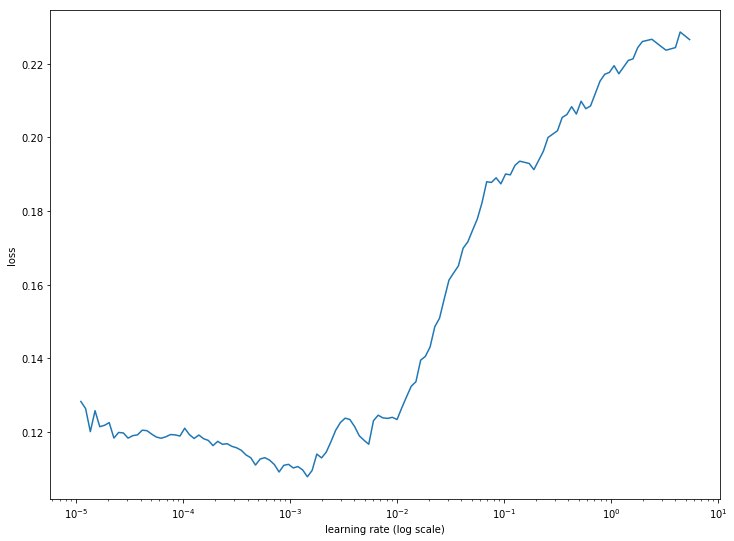

In [205]:
m.lr_find()
m.sched.plot(1)

In [221]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 10e-5 # * 5

/home/ubuntu/repos/fastai/fastai/column_data.py:101: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  for o in self.lins: kaiming_normal(o.weight.data)
/home/ubuntu/repos/fastai/fastai/column_data.py:103: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.outp.weight.data)


In [222]:
m.fit(lr,10, metrics=[exp_rmspe,mse]) #, cycle_len=1, cycle_mult=2


epoch      trn_loss   val_loss   exp_rmspe  mse        
    0      0.080877   0.059441   0.271593   0.335584  
    1      0.056558   0.05459    0.271951   0.31037   
    2      0.047135   0.040493   0.206696   0.283492  
    3      0.0374     0.051106   0.270912   0.30098   
    4      0.029905   0.036126   0.206007   0.259955  
    5      0.028116   0.041816   0.226424   0.279389  
    6      0.020508   0.034978   0.200828   0.259877  
    7      0.018463   0.033975   0.208094   0.252234  
    8      0.014524   0.037335   0.221873   0.265177  
    9      0.009949   0.035636   0.185931   0.271469  



[0.03563572047663129, 0.18593092987312215, 0.2714685505178819]

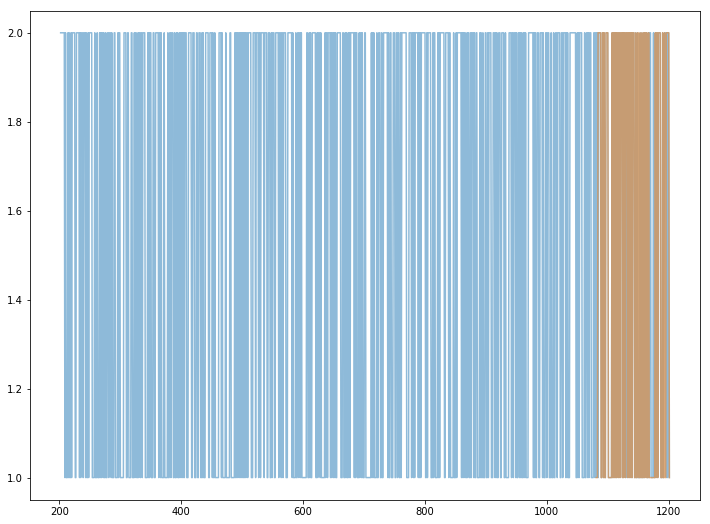

In [223]:
def create_output_df(m, idx):
    outp = pd.DataFrame({"ID":idx,
                         "actual":np.append([np.exp(m.data.trn_y)],[np.exp(m.data.val_y)]), 
                         "predicted":np.append([np.nan for i in m.data.trn_y],[np.round(np.exp(m.predict()))])})
#     outp = pd.DataFrame({"ID":idx,
#                          "actual":np.append([np.exp(m.data.trn_y)],[np.exp(m.data.val_y)]), 
#                          "predicted":np.append([np.nan for i in m.data.trn_y],[np.exp(m.predict())])})
    return(outp)

outp = create_output_df(m,sacf.index)
plt.plot(outp["actual"][-1000:], alpha = 0.5)
# plt.plot(outp["rand"][-1000:], alpha = 0.5)
plt.plot(outp["predicted"][-1000:], alpha = 0.5)
plt.show()


In [224]:
s = sacf[dep].std()
m = sacf[dep].mean()
l = len(sacf[dep])
dist = s * np.random.rand(l) + m

In [225]:
outp['predicted'] = np.round(outp['predicted'])
outp['dp'] = (outp['predicted'] - outp['actual']).abs()
outp['dr'] = np.round((dist - outp['actual']).abs())

print(outp['dp'].mean())
print(outp['dr'].mean())


0.10743801652892562
0.47254575707154745


In [226]:
print("Incorrect guesses:", outp['dp'].sum())
print("Incorrect randoms:", outp['dr'].sum())
print("Percentage accuracy:", 100 * (sum(val_idx) - outp['dp'].sum()) / len(val_idx))

Incorrect guesses: 13.0
Incorrect randoms: 568.0
Percentage accuracy: 114089.25619834711


In [227]:
outp.tail(121)

,ID,actual,predicted,dp,dr
1081,b'0000002401',2.0,1.0,1.0,0.0
1082,b'0000003402',1.0,1.0,0.0,1.0
1083,b'0000008369',2.0,1.0,1.0,0.0
1084,b'0000006138',1.0,2.0,1.0,1.0
1085,b'0000047834',2.0,2.0,0.0,0.0
1086,b'0000014705',2.0,2.0,0.0,0.0
1087,b'0000000958',2.0,2.0,0.0,0.0
1088,b'0000006939',2.0,2.0,0.0,0.0
1089,b'0000015103',1.0,1.0,0.0,1.0
1090,b'0000012456',1.0,1.0,0.0,1.0


In [ ]:
accuracy_np(m.predict(), yl)

In [ ]:
importfrom sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier matplotlib.pyplot as plt
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)
m = RandomForestClassifier(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);


In [ ]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(np.log(preds), np.log(y_val))


In [ ]:
preds

In [ ]:
y_val

In [ ]:
np.sum(np.abs(preds - y_val))

## Logistic Regression

In [ ]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
logreg = LogisticRegression()